In [6]:
For Pranav Krishna(359822) And Yerkin Yesbay

In [ ]:
import tarfile
import os

data_base_path = os.path.join('data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

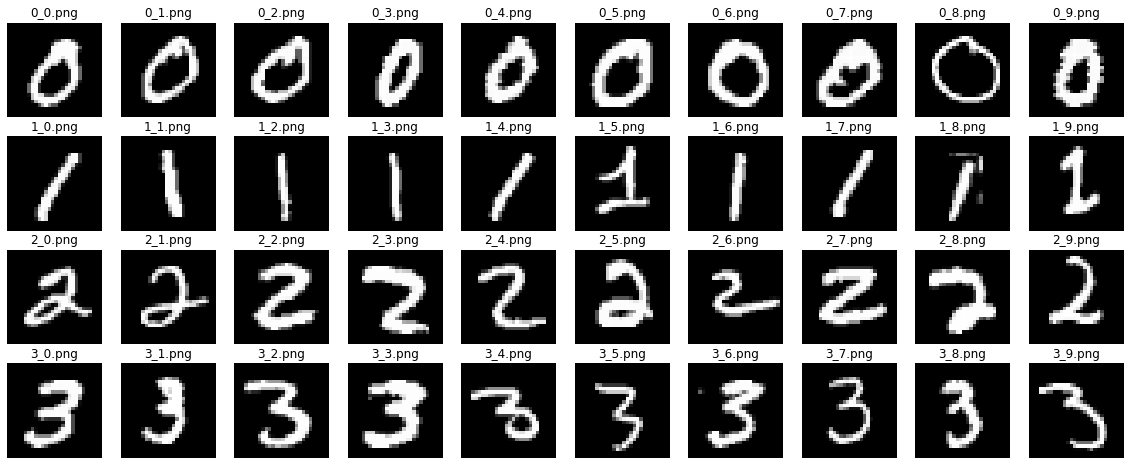

In [7]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
# Load digits data

# Zero images arrays
zeros_im, zeros_names = load(data_part1, digit='0')
# Ones images arrays
ones_im, ones_names = load(data_part1, digit='1')
# Twos images arrays
twos_im, twos_names = load(data_part2, digit='2')
# Threes images arrays
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 8))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

## 1.1. Preprocess and visualization (2 pts)

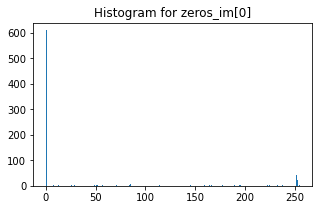

C:\Users\Pranav\AppData\Local\Temp\ipykernel_13448\3138792794.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


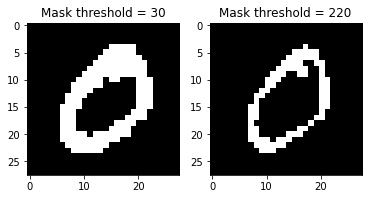

In [8]:
img = zeros_im[1]
plt.figure(figsize=(5,3))
plt.hist(img.flatten(),bins=256)
plt.title("Histogram for zeros_im[0]")
plt.show()
thresh_1 = 30
thresh_2 = 220

mask_1 = (img>thresh_1)
mask_2 = (img>thresh_2)
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
axs[0].imshow(mask_1,cmap='gray')
axs[0].set_title(f'Mask threshold = {thresh_1}')
axs[1].imshow(mask_2,cmap='gray')
axs[1].set_title(f'Mask threshold = {thresh_2}')
fig.show()

### Argument for the choice of threshold
The area of the digit varies significantly with the choice of binary threshold. To select the threshold in some probabilistically optimal way we need assumptions on the probability that a pixel belongs to the digit or background given the color. However the histograms don't give any useful probabilistic insights.

Let $f(i,j)$ be the true binary image (a pixel is white iff it belongs to the digit, otherwise black) and $g$ is the given image. It is reasonable to assume that for any $i, j \in \{0,\dots,image.shape[0]\}$ we have
$$P\left(f(i,j)=255 | g(i,j)\right) = g(i,j)/255,$$
that is the conditional probability of the true color being white is proportional to the color of the observed picture.

From this one can derive that the threshold T, that minimizes the expected error of misclassification, is T = 255/2. 

That is we assign $\hat f(i,j):=255$ iff $P\left(f(i,j)=255 | g(i,j)\right)>0.5$

### Removing small objects
Some artifacts, like those on 1_8.png can potentially be found in the images. We use *morphology.remove_small_objects* to get rid of them. The maximum size of removed object for each image is chosen to be 1/2 of the white area in the image

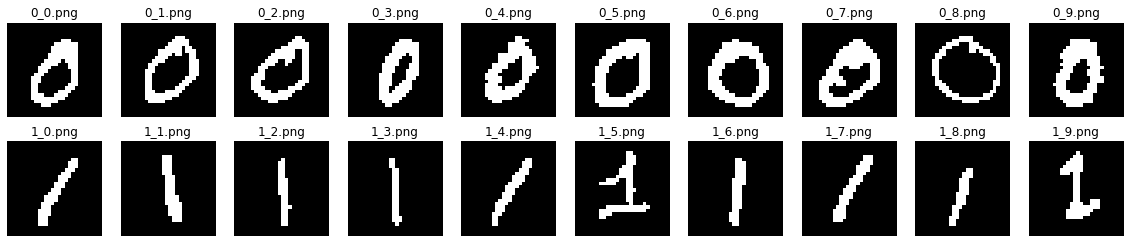

In [9]:
from skimage import morphology

vect_int = np.vectorize(int)

T = 255/2
zeros_mask = [(x>T) for x in zeros_im]
ones_mask = [(x>T) for x in ones_im]

#removal_size = min(np.sum(x) for x in zeros_mask+ones_mask)/2
for i in range(10):
    zeros_mask[i] = morphology.remove_small_objects(zeros_mask[i], np.sum(zeros_mask[i])/2)
for i in range(10):
    ones_mask[i] = morphology.remove_small_objects(ones_mask[i], np.sum(ones_mask[i])/2)

fig, axes = plt.subplots(2, len(zeros_mask), figsize=(20, 4))
for ax, im, nm in zip(axes[0], zeros_mask, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_mask, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [10]:
zeros_mask = [np.array(vect_int(x)*255,dtype='uint8') for x in zeros_mask]
ones_mask = [np.array(vect_int(x)*255,dtype='uint8') for x in ones_mask]

## 1.2 Get descriptors

We use *cv2.findContours* with *method= cv.CHAIN_APPROX_NONE* to extract the full sequence of points that belong to the contours. The function may return 2 or more sequences for zero (inner and outer contours), but we only take the outer one, which contains more points

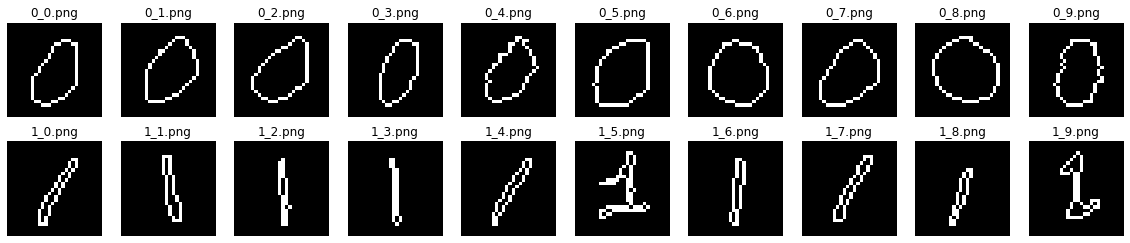

In [11]:
import cv2 as cv
from cv2 import findContours

#zeros_mask = [vect_int(x) for x in zeros_mask]
#ones_mask = [vect_int(x) for x in ones_mask]


def long_contour(img):
    contours = cv.findContours(img,mode=1,method= cv.CHAIN_APPROX_NONE)
    max_len = 0
    for contour in contours[0]:
        if len(contour)>max_len:
            max_len = len(contour)
            out = [list(x[0]) for x in contour]
    contour_image = np.zeros_like(zeros_mask[0])
    for i,j in out:
        contour_image[j][i]=1
    return out, contour_image

#plt.imshow(long_contour(zeros_im[0])[1],cmap='gray')
#plt.show()

fig, axes = plt.subplots(2, len(zeros_mask), figsize=(20, 4))
for ax, im, nm in zip(axes[0], zeros_mask, zeros_names):
    ax.imshow(long_contour(im)[1], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_mask, ones_names):
    ax.imshow(long_contour(im)[1], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

We define function *interp_contour* to produce a linear interpolation of the *contour* with the given number *n_nodes* of $almost$ $equidistant$ points. Complete equidistance of nodes is not guaranteed as the coordinates of the nodes can only take integer values

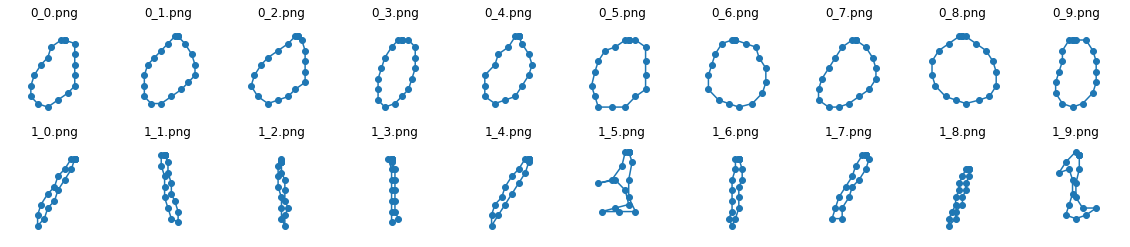

In [12]:
def interp_contour(contour,n_nodes):
    contour = np.array(contour)
    n = len(contour)
    perimeter = np.linalg.norm(contour[0]-contour[-1])
    for x in (contour[1:]-contour[:-1]):
        perimeter += np.linalg.norm(x)
    step_len = perimeter/n_nodes
    output = [contour[0]]
    k = 0
    for i in range(n_nodes-1):
        current_point = output[-1]
        current_len = 0
        while(current_len<=step_len and k<n):
            current_len=np.linalg.norm(contour[k]-current_point)
            k+=1
        #print(k)
        current_point = contour[k-1]
        output.append(current_point)
    return np.array(output)

n_nodes = 20
contours_0 = [interp_contour(long_contour(img)[0],n_nodes) for img in zeros_mask]
contours_1 = [interp_contour(long_contour(img)[0],n_nodes) for img in ones_mask]

fig, axes = plt.subplots(2, len(zeros_mask), figsize=(20, 4))
for ax, cont, nm in zip(axes[0], contours_0, zeros_names):
    ax.set_xlim(0,28)
    ax.set_ylim(0,28)
    ax.plot(cont[:,0],28-cont[:,1],marker='o')
    ax.axis('off')
    ax.set_title(nm)
for ax, cont, nm in zip(axes[1], contours_1, ones_names):
    ax.set_xlim(0,28)
    ax.set_ylim(0,28)
    ax.plot(cont[:,0],28-cont[:,1],marker='o')
    ax.axis('off')
    ax.set_title(nm)

Finally *fourier_descriptors* applies discrete Fourier transform to the interpolated contours of the image

In [13]:
from numpy import fft

def get_descriptors(img,size):
    contour = long_contour(img)[0]
    contour = interp_contour(contour,n_nodes=size)
    complex_contour = np.array([x[0]+x[1]*1j for x in contour])
    contour_fft = fft.fft(complex_contour)
    return contour_fft

get_descriptors(zeros_mask[0],size=20)

array([ 2.95000000e+02+2.57000000e+02j,  4.65927067e+01-1.58083843e+01j,
        9.10271276e+00-6.36025390e+00j, -1.69180471e+00+4.43526047e-01j,
        2.50000000e+00-1.79511318e+00j, -1.00000000e+00+3.00000000e+00j,
       -1.64249946e-01-1.87685379e+00j, -3.85209612e-01+2.56547266e-01j,
        2.50000000e+00+4.83672181e-02j,  1.49939089e-01+1.48214640e+00j,
       -1.00000000e+00+1.00000000e+00j,  1.62159714e+00-2.07586802e+00j,
        2.50000000e+00-1.57623126e+00j,  3.54900601e+00-5.65452107e-01j,
       -1.96036185e+00-5.95282162e-01j, -1.00000000e+00-5.00000000e+00j,
        2.50000000e+00-8.67702278e+00j,  7.08348200e-01+1.89169003e+00j,
        2.90218990e+01+1.28323899e+01j, -6.85445828e+01-1.33624205e+02j])

### Discussion

From the plots of interpolated contours we can see that zeros have elliptic shapes without high local variations, i.e. their interpolated contours look smoother. On the other hand ones seem rather to consist of straight lines with a few sharp breaks.

The different types of curviness of zeros and ones should reflect on the representation in the Fourier domain

## 1.3 Study effect of descriptors

In [14]:
def restore_k_descr(contour_fft,k):
    output = np.copy(contour_fft)
    output[k:] = 0 + 0*1j
    output = fft.ifft(output)
    return np.dstack((np.real(output),np.imag(output)))[0]

def contour_image(contour):
    output = np.zeros((28,28))
    for i,j in contour:
        output[int(j),int(i)] = 255
    return output

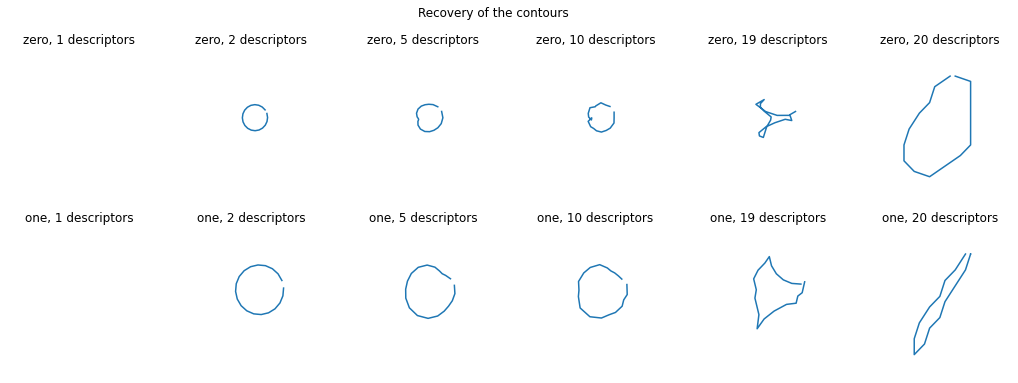

In [15]:
zero = zeros_mask[0]
one = ones_mask[0]

contour_len = 20
descr_set_sizes = [1, 2, 5, 10, 19, 20]

zero_desc = get_descriptors(zero,size=contour_len)
one_desc = get_descriptors(one,size=contour_len)


fig, axs = plt.subplots(nrows=2,ncols=len(descr_set_sizes),
                        figsize=(len(descr_set_sizes)*3,6))
for i in range(len(descr_set_sizes)):
    restored_zero = restore_k_descr(zero_desc,descr_set_sizes[i])
    restored_one = restore_k_descr(one_desc,descr_set_sizes[i])
    axs[0,i].set_xlim(0,28)
    axs[0,i].set_ylim(0,28)
    axs[0,i].plot(restored_zero[:,0],28-restored_zero[:,1])
    axs[0,i].axis('off')
    axs[0,i].set_title(f'zero, {descr_set_sizes[i]} descriptors')
    axs[1,i].set_xlim(0,28)
    axs[1,i].set_ylim(0,28)
    axs[1,i].plot(restored_one[:,0],28-restored_one[:,1])
    axs[1,i].axis('off')
    axs[1,i].set_title(f'one, {descr_set_sizes[i]} descriptors')
fig.suptitle("Recovery of the contours")
plt.show()

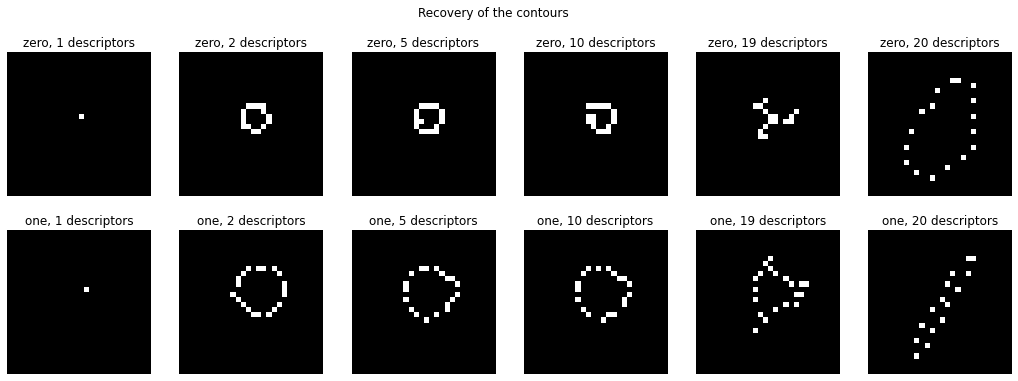

In [16]:
fig, axs = plt.subplots(nrows=2,ncols=len(descr_set_sizes),
                        figsize=(len(descr_set_sizes)*3,6))
for i in range(len(descr_set_sizes)):
    restored_zero = restore_k_descr(zero_desc,descr_set_sizes[i])
    restored_one = restore_k_descr(one_desc,descr_set_sizes[i])
    axs[0,i].imshow(contour_image(restored_zero),cmap='gray')
    axs[0,i].axis('off')
    axs[0,i].set_title(f'zero, {descr_set_sizes[i]} descriptors')
    axs[1,i].imshow(contour_image(restored_one),cmap='gray')
    axs[1,i].axis('off')
    axs[1,i].set_title(f'one, {descr_set_sizes[i]} descriptors')
fig.suptitle("Recovery of the contours")
plt.show()

### Discussion

After taking the inverse FT of the zero-padded Fourier representation, the obtained restored contour doesn't seem like the original contour even when we remove only the last frequency.
This is because the the last descriptors are very big in absolute values (see graph below). To get a better restoration of the original contours, one should keep the largest descriptors.

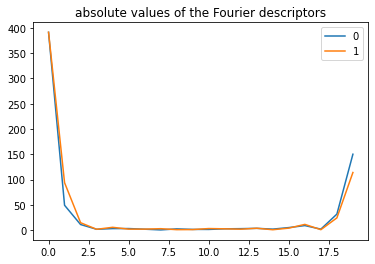

In [17]:
size = 20
plt.title("absolute values of the Fourier descriptors")
plt.plot(range(size),np.abs(get_descriptors(zeros_mask[0],size=size)),label='0')
plt.plot(range(size),np.abs(get_descriptors(ones_mask[0],size=size)),label='1')
plt.legend()

In [18]:
def restore_k_largest_descr(contour_fft,k):
    output = np.copy(contour_fft)
    sorted_lst = np.sorted(np.absolute(output))
    output[k:] = 0 + 0*1j
    output = fft.ifft(output)
    return np.dstack((np.real(output),np.imag(output)))[0]

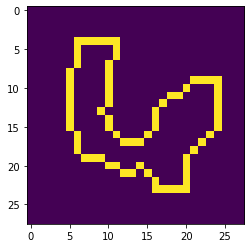

NameError: name 'fourier_function' is not defined

In [21]:
output = cv.findContours(twos_im[8],mode=1,method= cv.CHAIN_APPROX_NONE)
#output[1]
contour_in = [list(x[0]) for x in output[0][-1]]
contour_out = [list(x[0]) for x in output[0][0]]
contour_image = np.zeros_like(ones_im[0])
for i,j in contour_in:
    contour_image[i][j]=1
for i,j in contour_out:
    contour_image[i][j]=1
plt.imshow(contour_image)
plt.show()
complex_contour_in = list(map(lambda x: x[0]+x[1]*1j,contour_in))
complex_contour_out = list(map(lambda x: x[0]+x[1]*1j,contour_out))
contour_in_fft1 = fft.fft(complex_contour_in)
contour_out_fft1 = fft.fft(complex_contour_out)
fourier_function(contour_in_fft1,contour_out_fft1,2)

In [22]:
from sklearn.decomposition import PCA
k = 10
pca = PCA(n_components = k)
contour_in_fft1

array([ 1.02500000e+03+1.01000000e+03j, -1.43529263e+02-1.15852616e+02j,
       -1.00181966e+02+8.83998048e+01j,  9.18556635e+01+3.47672304e+01j,
       -9.90595615e+00-7.70841621e+00j, -2.77479438e+01-1.39146998e+01j,
        5.38117076e+00+8.75855339e+00j,  4.29986225e+00+2.88360676e+00j,
       -7.54831929e+00-5.11054488e+00j,  4.06576002e+00+1.69962157e+01j,
        6.11239058e+00-1.51189791e+00j,  6.53963221e+00+7.66340582e-01j,
       -2.37618882e+00+9.61830132e-01j,  4.10186359e-01-8.84053245e+00j,
        2.97740727e+00-3.83376289e+00j,  5.73455929e+00+2.65687576e+00j,
       -2.13451857e+00+3.99220711e-01j, -6.15159516e-01-2.84269331e+00j,
        2.13305110e+00-1.25560845e+00j,  1.01375158e-01+2.38135139e+00j,
       -2.80880725e+00-1.06728798e+00j,  2.44419344e-01-1.56535418e+00j,
        6.99473584e-01-3.16604785e+00j, -9.45293501e-01+2.35374605e+00j,
        2.31678657e+00-1.02818940e+00j, -2.50000000e+00-1.86602540e+00j,
        1.17639493e+00-7.99875999e-01j,  1.30805611

In [23]:
output = cv2.findContours(threes_im[0],mode=1,method= cv2.CHAIN_APPROX_NONE)
contour_in = [list(x[0]) for x in output[0][1]]
contour_out = [list(x[0]) for x in output[0][0]]
contour_image = np.zeros_like(zeros_im[0])
for i,j in contour_in:
    contour_image[i][j]=1
for i,j in contour_out:
    contour_image[i][j]=1
complex_contour_in = list(map(lambda x: x[0]+x[1]*1j,contour_in))
complex_contour_out = list(map(lambda x: x[0]+x[1]*1j,contour_out))
contour_in_fft = fft.fft(complex_contour_in)
contour_out_fft = fft.fft(complex_contour_out)
fourier_function(contour_in_fft,contour_out_fft,10)


NameError: name 'cv2' is not defined

# Task 2

In this section ,we use Region based descriptors to cluster and segment images. First, we extract the boundary of the figure using the fincdConours function from  openCV. Next, we use the length of the largest contour as the perimenter. FOr the area, we tried two things, the first being taking a normalised sum of the pixel values and the second being  thresholding and taking the number of non-zero pixels. In the code below, we show the largest contours for each instance of twos and threes.

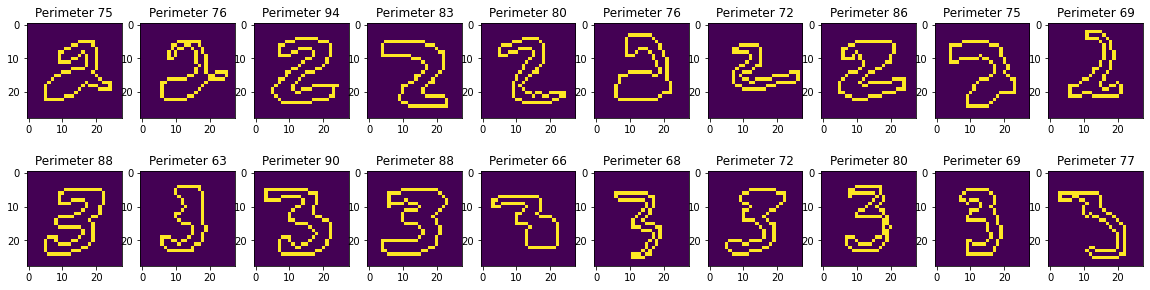

In [50]:
fig, axs = plt.subplots(ncols=10,nrows=2,figsize=(20,5))
for k in range(10):
    img2 = twos_im[k]
    img3 = threes_im[k]
    contours = cv.findContours(img2,mode=1,method=cv.CHAIN_APPROX_NONE)
    contour_img = np.zeros_like(img2)
    max_len = 0
    for contour in contours[0]:
        if len(contour)>max_len:
            max_len = len(contour)
            long_contour = [list(x[0]) for x in contour]
    for i,j in long_contour:
        contour_img[j][i]=1
    axs[0][k].imshow(contour_img)
    axs[0,k].set_title(f'Perimeter {max_len}')

    contours = cv.findContours(img3,mode=1,method=cv.CHAIN_APPROX_NONE)
    contour_img = np.zeros_like(img3)
    max_len = 0
    for contour in contours[0]:
        if len(contour)>max_len:
            max_len = len(contour)
            long_contour = [list(x[0]) for x in contour]
    for i,j in long_contour:
        contour_img[j][i]=1
    axs[1][k].imshow(contour_img)
    axs[1,k].set_title(f'Perimeter {max_len}')


Here, we try to use thresholding to find out the area. We try and reject the possibility of just computing the sum of all pixels to calculate the area. Then ,we settle on thresholding.

1.1052538801369758

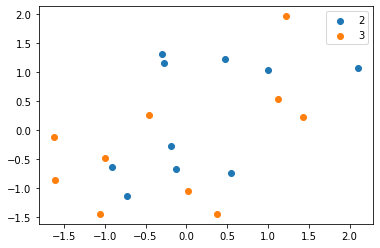

In [53]:
""" We tried this function to account for the possibility thatthe dim pixels can count less towards the area compared to the brighter pixels
def perimeter_area(img):
    contours = cv.findContours(img,mode=1,method=cv.CHAIN_APPROX_NONE)
    contour_img = np.zeros_like(img)
    max_len = 0
    for contour in contours[0]:
        contour = [list(x[0]) for x in contour]
        if len(contour)>max_len:
            max_len = len(contour)
            long_contour = np.array(contour)
        for i,j in contour:
            contour_img[i][j]=1
    perimeter = 0
    for x in (long_contour[1:]-long_contour[:-1]):
        perimeter += np.linalg.norm(x)
    area = np.sum(img/255)
    return [perimeter, area] """ 


def perimeter_area(img):
    contours = cv.findContours(img,mode=1,method=cv.CHAIN_APPROX_NONE)
    contour_img = np.zeros_like(img)
    max_len = 0
    for contour in contours[0]:
        contour = [list(x[0]) for x in contour]
        if len(contour)>max_len:
            max_len = len(contour)
            long_contour = np.array(contour)
        for i,j in contour:
            contour_img[i][j]=1
    perimeter = 0
    for x in (long_contour[1:]-long_contour[:-1]):
        perimeter += np.linalg.norm(x)
    #perimeter = max([len(contour) for contour in contours[0]])
    area = np.sum(img>200)
    return [perimeter, area]



features_2 = []
features_3 = []
for i in range(10):
    img_2 = twos_im[i]
    img_3 = threes_im[i]
    features_2.append(perimeter_area(img_2))
    features_3.append(perimeter_area(img_3))
features_2 = np.array(features_2)
features_3 = np.array(features_3)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(np.vstack([features_2,features_3]))
features_2 = scaler.transform(features_2)
features_3 = scaler.transform(features_3)

plt.scatter(features_2[:,0],features_2[:,1],label='2')
plt.scatter(features_3[:,0],features_3[:,1],label='3')
plt.legend()


In the previous plot, we see that the methods we used to calcuate the perimeter and area, even though appropriate, do not work well for clustering compared to the fourier descriptors. Now, we create the compacity feature. We observe from its 

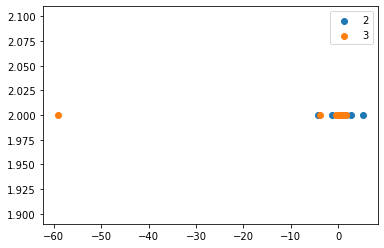

In [67]:
compacity_2 = features_2[:,1]/ features_2[:,0]
compacity_3 = features_3[:,1]/ features_3[:,0]

plt.scatter(compacity_2,np.repeat(2, len(compacity_2)),label='2')
plt.scatter(compacity_3,np.repeat(3, len(compacity_2)),label='3')
plt.legend()
plt.show()

We observe from this plot that the compacity feature cannot be reasonably expected to be a good way to cluster the twos and threes. This is because the high density areas for both of them are in the same region.

We observe that this definition of the compacity feature depends on the measurement units. To remove this dependence, we square the perimeter and divide by the area. By doing this, we see that the point clouds start to separate. 

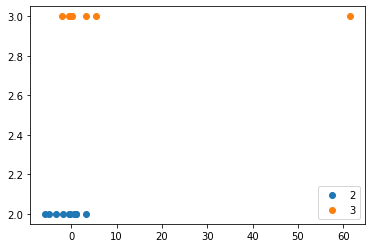

In [72]:
compacity_2 = features_2[:,1]**2/ features_2[:,0]
compacity_3 = features_3[:,1]**2/ features_3[:,0]

plt.scatter(compacity_2,np.repeat(2, len(compacity_2)),label='2')
plt.scatter(compacity_3,np.repeat(3, len(compacity_2)),label='3')
plt.legend()
plt.show()

We raise this compactness index to various powers and observe the results. In our experience, none of the powers we tried were useful. On trying to take the log, we obser the points separate, but not in a way conducive to clustering.

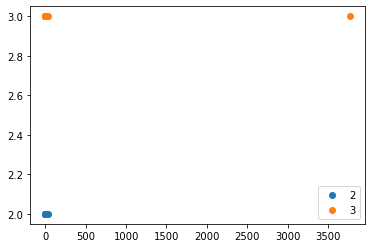

In [75]:
compacity_2 = (features_2[:,1]**2/ features_2[:,0])**2
compacity_3 = (features_3[:,1]**2/ features_3[:,0])**2

plt.scatter(compacity_2,np.repeat(2, len(compacity_2)),label='2')
plt.scatter(compacity_3,np.repeat(3, len(compacity_2)),label='3')
plt.legend()
plt.show()


C:\Users\Pranav\AppData\Local\Temp\ipykernel_13448\3462440257.py:1: RuntimeWarning: invalid value encountered in log
  compacity_2 = np.log(features_2[:,1]**2/ features_2[:,0])
C:\Users\Pranav\AppData\Local\Temp\ipykernel_13448\3462440257.py:2: RuntimeWarning: invalid value encountered in log
  compacity_3 = np.log(features_3[:,1]**2/ features_3[:,0])


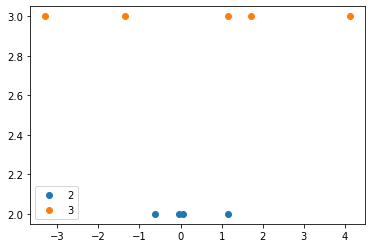

In [76]:
compacity_2 = np.log(features_2[:,1]**2/ features_2[:,0])
compacity_3 = np.log(features_3[:,1]**2/ features_3[:,0])

plt.scatter(compacity_2,np.repeat(2, len(compacity_2)),label='2')
plt.scatter(compacity_3,np.repeat(3, len(compacity_2)),label='3')
plt.legend()
plt.show()